# Problem Set 4

# Demand:

Consumer $i's$ preference for product $j$ and market $m$ is assumed to take the following form: 
$$
U_{ijm} = X_{jm}\beta -\alpha_i p_{jm} + \xi_{jm} + \epsilon_{ijm}
$$
$$
\alpha_i = \alpha + \sigma_\alpha v_{ip}
$$
$$
U_{i0} = 0
$$

In [175]:
# Import the needed libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from scipy.optimize import root, minimize, LinearConstraint, NonlinearConstraint
import matplotlib.pyplot as plt
from jax import grad, jacobian, hessian
import jax.numpy as jnp

In [176]:
k = np.arange(10).reshape(5, 2)
k.flatten()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [177]:
# Set global parameter values
beta = (5, 1, 1)
gamma = (2, 1, 1)

In [178]:
def load_mat_data(datapath, nrProducts, nrMarkets):
    """
    Purpose: Loads a .mat data file and returns a Pandas DataFrame.

    Parameters
    ----------
    datapath : str
        The path to the .mat file.

    nrProducts : int
        The number of products in the market data.
    
    nrMarkets : int
        The number of markets in the market data.
        
    Returns
    -------
    pd.DataFrame
        The market level data in the .mat data file converted to a Pandas DataFrame.
    pd.DataFrame
        The simulated alphas in the .mat data file converted to a Pandas DataFrame.
        
    Description
    -----------
    This function loads the .mat data using scipy.io.loadmat and collects the variable names and the 
    data (in numpy arrays), ignoring other items in the dictionary (such as the header). It then converts
    the cleaned dictionary into two DataFrames, one for the market level data and one for the simulated alphas in each market.
    """

    # Load the .mat data and format the X's appropriately
    mat = loadmat(datapath)
    mat = {k:v for k, v in mat.items() if k[0] != '_'}
    mat['x2'] = mat['x1'][:, 1]
    mat['x3'] = mat['x1'][:, 2]
    mat['x1'] = mat['x1'][:, 0]

    # Get the simulated alphas into one DataFrame
    alphas = mat['alphas']
    column_names = [i for i in range(alphas.shape[1])]
    df_alphas = pd.DataFrame(alphas, columns=column_names)
    mat.pop('alphas')

    # Store the market level data to a DataFrame
    df_mkt = pd.DataFrame({k: np.array(v).flatten(order='F') for k, v in mat.items()})

    # Add market and product ids to the market level data
    product_ids = [i+1 for i in range(nrProducts)] * nrMarkets
    market_ids = [i+1 for i in range(nrMarkets) for _ in range(nrProducts)]
    df_mkt['market_id'] = market_ids
    df_mkt['product_id'] = product_ids
    
    return df_mkt, df_alphas

In [179]:
def draw_epsilons(alphas):
    """
    Purpose: Draws epsilons from the specified distribution, to the same shape as alphas.

    Parameters
    ----------
    alphas : pd.DataFrame
        The DataFrame of alphas, in the form (Number of Consumers) x (Number of Markets).
        
    Returns
    -------
    pd.DataFrame
        The simulated epsilons in a Pandas DataFrame.
        
    Description
    -----------
    This function takes the simulated alphas for all consumers in all markets and simulates epsilons for each of them.
    """
    draws = np.random.gumbel(size=(alphas.shape[0], alphas.shape[1]))
    column_names = [i+1 for i in range(draws.shape[1])]
    df_epsilons = pd.DataFrame(draws, columns=column_names)
    return df_epsilons

# Elements of this matrix: 

### Demand Side:
* $x1$: The "constant" product characteristic, which is always equal to 1.
* $x2$: The second product characteristic, $X_{2, jm}\sim U[0,1]$
* $x3$: The third product characteristic, $X_{3, jm}\sim N(0,1)$
* $xi\_all:$ The mean utility of the product, $\xi_{jm}\sim N(0,1)$, also known as the unobserved product characteristics.
* $alphas:$ The individual's price sensitivity which is equal to $\alpha_i = \alpha + \sigma_a v_{ip}$, where $v_{ip}\sim LN(0, 1)$

### Supply Side:
* $w$: An imput cost shifter (wage) used for to produce product $j$, constant across markets. $W_j\sim N(0, 1)$. This is a common cost shifter for firm $j$ across all markets. 
* $Z$: An imput cost shifter which is different depending on the product AND the market: $Z_{jm} \sim N(0, 1)$
* $eta:$ A marginal cost shock to product $j$, market $m$: $\eta_{jm}\sim N(0, 1)$
* $P\_opt:$ The firm's optimal price.
* $shares:$ The market share of product $j$ in market $m$, $s_{jm}$. Note that since all firms are single-product firms, this is basically "firm j's share in market m."

In [180]:
df_3p, alphas_3p = load_mat_data('Simulation Data/100markets3products.mat', 3, 100)
df_5p, alphas_5p = load_mat_data('Simulation Data/100markets5products.mat', 5, 100)

In [181]:
epsilons_3p = draw_epsilons(alphas_3p)
epsilons_5p = draw_epsilons(alphas_5p)

In [182]:
# Calculate marginal costs for the firms
df_3p['mc'] = gamma[0] + gamma[1]*df_3p['w'] + gamma[2]*df_3p['Z'] + df_3p['eta']
df_5p['mc'] = gamma[0] + gamma[1]*df_5p['w'] + gamma[2]*df_5p['Z'] + df_5p['eta']

In [183]:
# Calculate profits per purchase for the firms
df_3p['Pi'] = df_3p['P_opt'] - df_3p['mc']
df_5p['Pi'] = df_5p['P_opt'] - df_5p['mc']

In [184]:
def calculate_welfare(data, alphas, epsilons):
    """
    Purpose: Calculates the consumer welfares based on the given market level data and the simulated consumers.

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame of market level data.

    alphas : pd.DataFrame
        The DataFrame of alphas, in the form (Number of Consumers) x (Number of Markets).

    epsilons : pd.DataFrame
        The DataFrame of epsilons, in the form (Number of Consumers) x (Number of Markets).
        
    Returns
    -------
    np.array
        The (Number of Consumers) x (Number of Markets) array of utilities (welfare) of each consumer in each market, conditional
        on them choosing optimally based on their utility function.
        
    Description
    -----------
    This function takes the market level data, and simulated alphas and epsilons and calculates the welfare for each consumer in each market,
    conditional on them choosing optimally based on their utility function parameters.
    """
    # Check that the alphas and epsilons agree on the number of markets
    assert len(alphas) == len(epsilons)

    # Store number of markets
    nrMarkets = len(alphas)

    # Store number of products
    nrProducts = data['product_id'].max()
    
    for market_id in range(1, nrMarkets+1):
        # Get the data for the market at hand
        mkt_data = data.loc[data['market_id']==market_id].copy()
        
        # Calculate the part of the utility that is independent from the consumer
        mkt_data['common_util'] = beta[0]*mkt_data['x1'] + beta[1]*mkt_data['x2'] + beta[2]*mkt_data['x3'] + mkt_data['xi_all']
        
        # Calculate consumer utilities
        utils = {}
        for product in range(1, nrProducts+1):
            utils[product] = (
                -alphas.iloc[market_id-1].values*mkt_data.loc[mkt_data['product_id']==product]['P_opt'].iloc[0]
                + epsilons.iloc[market_id-1].values
                + mkt_data.loc[mkt_data['product_id']==product]['common_util'].iloc[0]
            )

        # Stack utilities for each product in the market for each consumers into a matrix
        product_utilities = np.stack(tuple(utils.values()), axis=1)

        # Create a column of zeros with the same number of rows as there are consumers
        zero_column = np.zeros((product_utilities.shape[0], 1))
        
        # Concatenate the zero column to 'product_utilities', to store the utility from the outside option (zero)
        product_utilities = np.concatenate([product_utilities, zero_column], axis=1)

        mkt_welfare = np.amax(product_utilities, axis=1).reshape(500, -1)
        
        if market_id == 1:
            market_welfares = mkt_welfare
        else:
            market_welfares = np.hstack([market_welfares, mkt_welfare])
            
    return market_welfares

In [185]:
consumer_welfare_3p = calculate_welfare(df_3p, alphas_3p, epsilons_3p)
consumer_welfare_5p = calculate_welfare(df_5p, alphas_5p, epsilons_5p)

In [186]:
def plot_two_histograms(data1, data2, bins=500, labels=('Data 1', 'Data 2')):
    """
    Purpose: Plots two histograms side by side to compare the distributions of two different datasets.

    Parameters
    ----------
    data1 : np.array
        The first dataset, which can be a multi-dimensional NumPy array. All elements will be flattened for the histogram.
    
    data2 : np.array
        The second dataset, which can also be a multi-dimensional NumPy array. All elements will be flattened for the histogram.
    
    bins : int, optional
        The number of bins for each histogram (default is 50).
    
    labels : tuple of str, optional
        Labels for each dataset, used in the titles of the histograms (default is ('Data 1', 'Data 2')).
        
    Description
    -----------
    This function takes two datasets, flattens them into 1-dimensional arrays if necessary, and plots them as two
    histograms side by side in a single figure. It provides a visual comparison of the distributions in both datasets.
    """
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the first histogram
    axes[0].hist(data1.flatten(), bins=bins)
    axes[0].set_title(f'{labels[0]}')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    
    # Plot the second histogram
    axes[1].hist(data2.flatten(), bins=bins)
    axes[1].set_title(f'{labels[1]}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

### NOTE: Some prices are negative and some profits per sale of a product as well. I think we might need to account for this by allowing firms to exit. I asked Jake, let's see what he says.

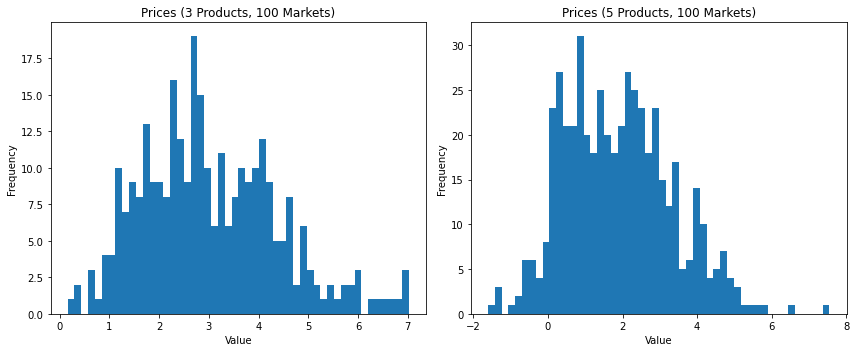

In [187]:
plot_two_histograms(df_3p['P_opt'].values, df_5p['P_opt'].values, bins=50, labels=('Prices (3 Products, 100 Markets)', 'Prices (5 Products, 100 Markets)'))

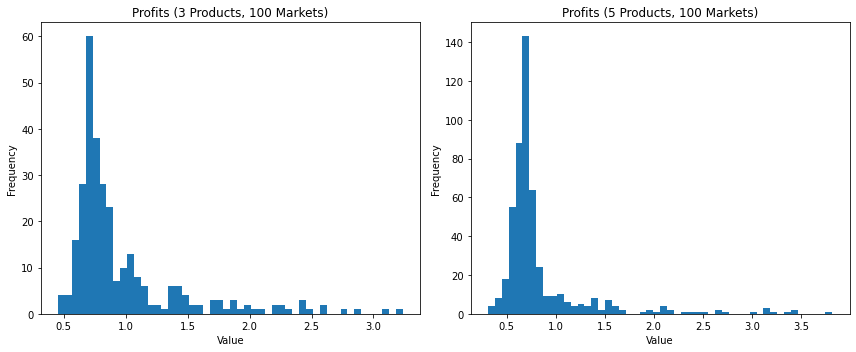

In [188]:
# NOTE: This is incomplete. Need to calculate gross profits accounting for the consumer choices. Currently, it's just per purchase profits.

plot_two_histograms(df_3p['Pi'].values, df_5p['Pi'].values, bins=50, labels=('Profits (3 Products, 100 Markets)', 'Profits (5 Products, 100 Markets)'))

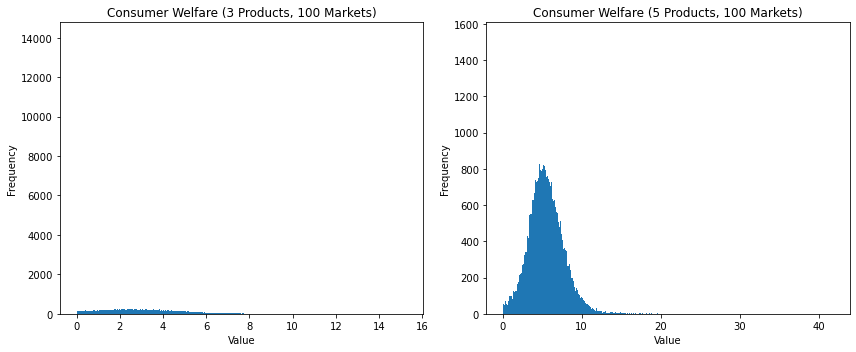

In [189]:
plot_two_histograms(consumer_welfare_3p, consumer_welfare_5p, labels=('Consumer Welfare (3 Products, 100 Markets)', 'Consumer Welfare (5 Products, 100 Markets)'))

# 2. BLP and Hausman Instruments

In [192]:
# Set the number of firms, markets, and simulated consumers in each market 
J = 3
M = 100
N = 500

In [194]:
# Set the number of BLP instruments
N_instruments = 6

### 1. (a)

NOTE: We assume the question asks us to use the $(J, M) = (3, 100)$ data set, since there is no data with 200 markets.

### Hausman instruments (prices in other markets)

In [196]:
df_3p['P_other_markets'] = df_3p.groupby('product_id')['P_opt'].transform(
        lambda x: (x.sum() - x) / (len(x) - 1)
    )

### BLP instruments (characteristics as instruments). 

In [205]:
xi = df_3p['xi_all'].values.reshape(J*M, 1)
X = df_3p[['x1', 'x2', 'x3']].values.reshape(J*M, 3)
price = df_3p['P_opt'].values.reshape(J*M, 1)
price_other_mkt = df_3p['P_other_markets'].values.reshape(J*M, 1)

#Additionally, defining other variables which are used later
prices=price.reshape(J*M, 1) 
shares = df_3p['shares'].values.reshape(J*M, 1)

#Get matrix of regressors
Xbar = df_3p[['x1', 'x2', 'x3', 'P_opt']].values.reshape(J*M, 4)

In [198]:
(xi*X).mean(axis=0)

array([0.04346104, 0.02074192, 0.0355315 ])

In [207]:
(xi*price).mean()

0.2949581371489729

In [208]:
(xi*price_other_mkt).mean()

0.1436795476746802

### 1. (b)

Consider $E[\xi|X] = 0$ first. For the moment condition to be valid for all $X$ (including the firm's own product characteristics), we would need the observable product characteristics $X_{jm}$ to be independent of the unobserved product characteristics (or things like market-specific brand value), $\xi_{jm}$. In practice, this would mean that firms with certain types of observable product characteristics do not have systematically different unobserved product characteristics. This seems unlikely to hold in practice, since firms are able to both see the unobserved (to the econometrician) product characteristics before choosing the observed (again, to the econometrician) product characteristics. For example, we would expect that a "premium" car (something that is in $\xi$) typically has different product characteristics that a non-premium car. Still, to know whether this moment condition would be valid in this context, we would need more information on what type of products we are studying.

The moment condition is relevant though, as long as $X$ is included $Z_{jm}$, i.e. the product characteristics are costly. The relevance is then clear from the fact that prices are a function of marginal costs, which are a function of $X$.  

As for $E[\xi|p] = 0$, the validity depends on which prices we consider. With own prices, it's clear that validity is not satisfied, since in general, prices are higher for products with greater $\xi$, as firms choose prices with knowledge of their market-specific $\xi_{jm}$. But the mean independence might be satisfied for own prices in other markets (Hausman instruments), if we include firm fixed effects to control for the firm-level component of $\xi$ that is invariant accross markets and construct the moment condition with the market-specific part of $\xi$. Note that relevance is trivially satisfied in both these cases, since (1) prices are obviously correlated with themselves, and (2) prices in other markets are correlated with prices in a specific market because there is a common cost shifter for all markets, $W_j$. 

### 1. (c)

If the way firms choose product characteristics $X$ is such that the unobserved product characteristics are not observed before choosing observable characteristics, the BLP instruments can be used. Similarly, in the previous part we have argued that the Hausman instruments are relevant, and are also valid if there are e.g. no demand shocks that are common accross all markets or marketing campaings of the firms that include multiple markets.

### 2. (a)

To begin, we introduce some notation that is useful throughout the rest of the problem set. Let $S_{jm}$ be the observed market share of product $j$ in market $m$, and $S_m \equiv (S_{jm})_{j = 1}^J$. For each value of the parameter values $\theta$, there exists a unique mapping (as shown by Berry, 1994) between the observed market shares, $S_m$, and the vector of unobserved demand shocks $\xi_m$, defined by $s(\cdot)$:
$$
S_m = s(X_m, p_m, \xi_m; \theta),
$$
where the $X_m$ is the matrix of observed product characteristics, $p_m$ the vector of prices, and $\xi_m$ the vector of unobserved demand shocks, all in market $m$. The uniqueness of the mapping allows us to invert the market share function to arrive at:
$$
\xi_m(\theta) = s^{-1}(S_m; \theta),
$$
where we have shortened $s(\xi_m; \theta) \equiv s(X_m, p_m, \xi_m; \theta)$ for notational convenience. Finally, denote $\xi(\theta) = (\xi_m(\theta))_{m = 1}^M$.

We next write down the BLP moments. First, let $h(X, j, m)$ be a vector valued function of moments for firm $j$ in market $m$, based on all the observable product characteristics $X$ for all products and markets. The BLP instruments are the (observable) product characteristics of the firm $X_{jm}$, the sum of the characteristics of other products of the firm (in other markets) $\sum_{r \neq j, m' \neq m, r \in \mathcal{F}_j} X_{rm'}$, and the characteristics of other firms in the same market $\sum_{r \neq \mathcal{F}_j} X_{rm}$. We exclude the first element of $X_{jm}$, the constant, from all these instruments. Since there are two other product characteristics, $h(X)$ is a vector with $2 \times 3 = 6$ elements for each firm. The BLP moment is thus:
$$
E[\xi_{jm}h(X, j)] = 0.
$$

The empirical analogue of the BLP moment is:
$$
g(\xi(\theta)) = \frac{1}{M}\Sigma_{m = 1}^M \Sigma_{j = 1}^J \xi_{jm} h(X, j, m).
$$
Let $s^{-1}_j(S_m; \theta)$ denote the $j$th element of $s^{-1}_j(S_m; \theta)$. We thus have:
$$
g(\xi(\theta)) = \frac{1}{M}\Sigma_{m = 1}^M \Sigma_{j = 1}^J s^{-1}_j(S_m; \theta) h(X, j, m).
$$

### 2. (b)

The objective function in the MPEC problem is simply:
$$
Q(\theta) \equiv g(\xi(\theta))^T W g(\xi(\theta)),
$$
for some weighting matrix $W$. We can thus write the MPEC problem in its entirety as:
$$
\begin{aligned}
\min _{\theta, \xi, \eta} \eta^{\prime} W \eta & \\
\text { subject to } & g(\xi)=\eta, \\
& s(\xi ; \theta)=S.
\end{aligned}
$$

## "Deltas" Version:

$$
s(\delta, \sigma_\alpha) = \frac{1}{N} \sum_{i=1}^N \left(\frac{\exp(\delta_{jm}+\mu_{ijm})}{1+ \sum_{k=1}^J \exp(\delta_{km}+\mu_{ikm})}\right)
$$

Here, $\delta$ is a guess of $JM$ product-market mean utilities. $\sigma_\alpha$ determines $\mu_{ijm}$, which is given by 

$$
    \mu_{ijm} = -\sigma_\alpha v_{im} p_{jm}
$$

We use the parameter vector 

$$
\operatorname{params} = \left[\sigma_\alpha, \mathbf \delta\right]
$$


In [209]:
sigma_alpha_init = 1
eta_init =  jnp.ones((N_instruments, 1))
delta_init = jnp.ones((J*M, 1))
params_init = jnp.concatenate([np.array([sigma_alpha_init]).reshape(-1,1), eta_init, delta_init], axis=0).flatten()

#For speed, compute this outside of the function and pass it later
alphas_repeat = jnp.repeat(np.array(alphas_3p.values), repeats=J, axis=0)

# Random coefficients nu on the prices
nus = (alphas_repeat-1) * prices.reshape(-1, 1)

"true" parameters to check if my share function is working


In [210]:
sigma_alpha_true = 1
#eta_init =  jnp.ones((N_instruments, 1))
beta_and_alpha_true = np.array([5, 1, 1, -1]).reshape(-1, 1)

delta_true = Xbar @ beta_and_alpha_true + xi

params_true = jnp.concatenate([np.array([sigma_alpha_true]).reshape(-1,1), eta_init, delta_true], axis=0).flatten()
params=np.array(params_true)

In [215]:
#Version fixing the bugs 
def s(params):
    sigma = params[0]
    deltas = params[N_instruments+1:].reshape(-1, 1)
    num = jnp.exp(deltas - sigma*nus)
    #Sum used in the denominator
    market_sums = 1 + num.reshape(M, J, N).sum(axis=1).reshape(M, -1)
    #Need to repeat it to make it the same size as the numerator
    denom = jnp.repeat(market_sums, repeats=J, axis=0)
    out = (num/denom).sum(axis=1)/N
    return out

def s1(params):
    sigma = params[0]
    deltas = params[N_instruments+1:].reshape(-1, 1)
    
    # Compute utilities
    utilities = deltas - sigma * nus  # Shape: (M*J, N)
    
    # Reshape utilities for markets and products
    utilities_reshaped = utilities.reshape(M, J, N)  # Shape: (M, J, N)
    
    # Compute the stabilization constant (max utility per market per individual)
    max_utilities = jnp.max(utilities_reshaped, axis=1, keepdims=True)  # Shape: (M, 1, N)
    
    # Stabilized exponentials (numerator and denominator terms)
    exp_utilities = jnp.exp(utilities_reshaped - max_utilities)  # Shape: (M, J, N)
    sum_exp_utilities = 1 + exp_utilities.sum(axis=1, keepdims=True)  # Add 1 for outside good
    
    # Compute shares
    shares = exp_utilities / sum_exp_utilities  # Shape: (M, J, N)
    
    # Average across individuals
    avg_shares = shares.mean(axis=2)  # Shape: (M, J)
    
    # Flatten output to match the original function's shape
    return avg_shares.flatten()

In [212]:
s0_test = s(params_init)
s1_test = s1(params_init)
s0_true = s(params_true)

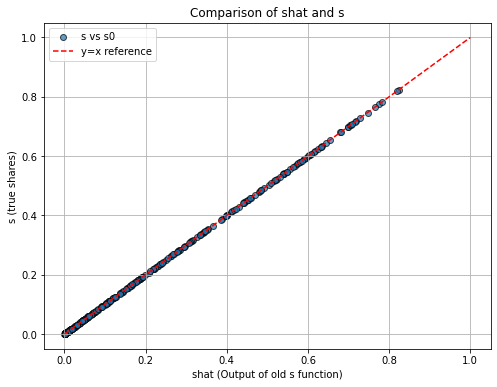

In [213]:
# Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(s0_true, shares, alpha=0.7, edgecolor='k', label="s vs s0")

# Add labels and a diagonal line for reference
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="y=x reference")
plt.xlabel("shat (Output of old s function)")
plt.ylabel("s (true shares)")
plt.title("Comparison of shat and s")
plt.legend()
plt.grid(True)
plt.show()

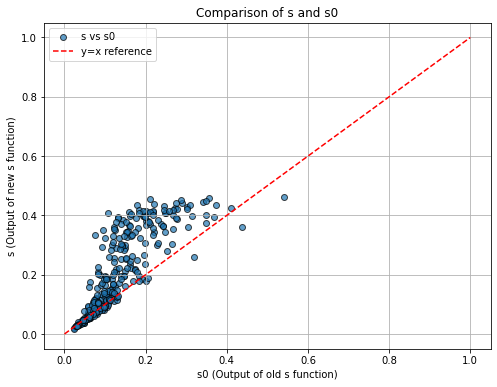

In [216]:
# Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(s0_test, s1_test, alpha=0.7, edgecolor='k', label="s vs s0")

# Add labels and a diagonal line for reference
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="y=x reference")
plt.xlabel("s0 (Output of old s function)")
plt.ylabel("s (Output of new s function)")
plt.title("Comparison of s and s0")
plt.legend()
plt.grid(True)
plt.show()

### Instruments function
Creates a $(J\cdot M \times n_\text{instruments})$ matrix of instruments.

Thoughts: Should we also include the $X=1$ as one of the instruments so that $E[\xi] = 0$ is one of our moment conditions?

In [218]:
def blp_instruments_all(X):
    """
    Computes the matrix of instruments for all (j, m) pairs in a vectorized manner.
    
    Parameters:
    ----------
    X : jnp.ndarray
        Input matrix of shape (J * M, features).
        
    Returns:
    -------
    instruments : jnp.ndarray
        Matrix of instruments for all (j, m), shape (J * M, 6).
    """
    
    # Reshape X into (M, J, features)
    # Note: for instruments, use only the nonconstant product characteristics.
    #X_reshaped = X[:, 1:].reshape(M, J, -1)  # Shape: (M, J, features)
    X_reshaped = X[:, 1:].reshape(M, J, -1)  # Shape: (M, J, features)

    # First two elements: Features of product j in market m
    X_jm = X_reshaped  # Shape: (M, J, features)

    # Next two elements: Sum of product j's features in all other markets
    X_j_sum = jnp.sum(X_reshaped, axis=0, keepdims=True) - X_reshaped  # Shape: (M, J, features)

    # Last two elements: Sum of all other products' features in the same market
    X_m_sum = jnp.sum(X_reshaped, axis=1, keepdims=True) - X_reshaped  # Shape: (M, J, features)
    
    # Concatenate results along the last dimension
    instruments = jnp.concatenate([X_jm, X_j_sum, X_m_sum], axis=-1)  # Shape: (M, J, 6)
    
    # Reshape back to (J * M, 6)
    return instruments.reshape(J * M, -1)

In [219]:
#Get the matrix of instruments (including x1, x2, and the BLP moments). 
Z = jnp.array(blp_instruments_all(X))
#Construct the annihilator matrix
Pz = Z@jnp.linalg.inv(Z.T@Z)@Z.T
Az = jnp.eye(Pz.shape[0]) - Xbar@jnp.linalg.inv(Xbar.T@Pz@Xbar)@Xbar.T
W = jnp.eye(N_instruments)

#### Note: DFS use a one-step GMM using W = $\left(Z^\intercal Z\right)^{-1}$

### Note: The instruments should be the same for all "runs" of the blp objective function. Don't need to re-calculate the BLP instruments each time. 

In [220]:
def blp_moment(params):
    """
    Computes the BLP moment vector using vectorized instruments.
    
    Parameters:
    ----------
    params : array-like
        Model parameters.
    X : jnp.ndarray
        Input data matrix of shape (J * M, features).
        
    Returns:
    -------
    sum_vec : jnp.ndarray
        The moment vector divided by the number of markets, shape (instrument_features,).
    """
    deltas = params[1+N_instruments:].reshape(-1, 1)  # Shape: (J * M, 1)
    xis = Az@deltas #use the annihilator matrix to recover xi
    sum_vec = jnp.sum(xis * Z, axis=0)  # Shape: (instrument_features,)
    return (sum_vec / (J*M)) #Should we also divide by J?

In [221]:
blp_ans = blp_moment(params_init)

In [31]:
#params_init[5:5+N_instruments]

In [222]:
def objective_mpec(params, W):
    eta = jnp.array(params[1:1+N_instruments])
    out = eta.T @ W @ eta
    return out

In [223]:
objective_mpec(params_init, W)

Array(6., dtype=float32)

In [224]:
def constraint_g(params):
    g_xi = blp_moment(params)
    eta = params[5:5+N_instruments]
    return g_xi - eta

In [225]:
cg_ans = constraint_g(params_init)
cg_ans.shape

(6,)

In [226]:
def constraint_s(params):
    deltas = params[1+N_instruments:] 
    return s(params) - shares.flatten()

In [227]:
cs_ans = constraint_s(params_init)
cs_ans.shape

(300,)

In [228]:
objective = lambda x: objective_mpec(x, W)

In [229]:
aaa = objective(params_init)

In [230]:
#Jax Autograd gradient
auto_jac = grad(objective, argnums = 0)
auto_hess = hessian(objective, argnums = 0)

In [231]:
def objective_jac(params):
    # Extract etas
    eta = params[1:1+N_instruments]
    grad_eta = 2 * W @ eta  # Gradient for eta

    # Build the full gradient vector
    grad = np.zeros_like(params)  # Use NumPy for the full gradient
    grad[1:1+N_instruments] = np.array(grad_eta)  # Convert JAX array to NumPy
    return grad

In [232]:
our_jac_init = objective_jac(params_init)
autojac_init = np.array(auto_jac(params_init))

max(abs(our_jac_init-autojac_init))

0.0

In [233]:
def objective_hess(params):
    # Initialize the full Hessian matrix
    hess = np.zeros((len(params), len(params)))
    # Fill in the block corresponding to etas
    hess[1:1+N_instruments, 1:1+N_instruments] = 2 * W  # Constant Hessian for etas
    return hess

### Checking the Hessian against Autograd
Turns out the manually coded Hessian is faster to evaluate. 

In [234]:
our_hess_init = objective_hess(params_init); 
autohess_init = np.array(auto_hess(params_init))
np.max(abs(our_hess_init-autohess_init))
#max(max(abs(our_hess_init-autohess_init)))

0.0

In [236]:
# Compute the Jacobian of the g constraint
def constraint_g_jac(params):
    return jacobian(constraint_g)(jnp.array(params))

In [237]:
cg_jac_init = np.array(constraint_g_jac(params_init))

In [238]:
# Compute the Jacobian of the s constraint
def constraint_s_jac(params):
    return jacobian(constraint_s)(jnp.array(params))

In [239]:
cs_jac_init = np.array(constraint_s_jac(params_init))

In [240]:
# Define the constraints list
constraints = [
    {
        'type': 'eq',  # Equality constraint g(x) = eta
        'fun': lambda x: np.asarray(constraint_g(x)),  # Convert to NumPy
        'jac': lambda x: np.asarray(constraint_g_jac(x))  # Convert Jacobian to NumPy
    },
    {
        'type': 'eq',  # Equality constraint s(x) = shares
        'fun': lambda x: np.asarray(constraint_s(x)),
        'jac': lambda x: np.asarray(constraint_s_jac(x))
    }
]

In [241]:
cg = NonlinearConstraint(lambda x: np.asarray(constraint_g(x)), 0, 0, jac = constraint_g_jac)
cs = NonlinearConstraint(lambda x: np.asarray(constraint_s(x)), 0, 0, jac = constraint_s_jac)

constraints = [cg, cs]

In [242]:
# Test objective
print("Objective value:", objective_mpec(params_init, W))

# Test gradients
print("Gradient shape:", objective_jac(params_init).shape)

# Test constraints
print("Constraint g:", constraint_g(params_init))
print("Constraint g Jacobian shape:", constraint_g_jac(params_init).shape)
print("Constraint s:", constraint_s(params_init))
print("Constraint s Jacobian shape:", constraint_s_jac(params_init).shape)

Objective value: 6.0
Gradient shape: (307,)
Constraint g: [-0.99999875 -0.9999999  -1.1376449  -0.9959361  -1.003076   -1.0008917 ]
Constraint g Jacobian shape: (6, 307)
Constraint s: [ 2.5780963e-02 -5.1651216e-01  3.0464329e-02 -1.7978996e-04
  8.9843065e-02 -4.6751201e-01 -1.0538940e-01 -5.6697942e-02
 -1.3125893e-01  6.4022213e-02 -3.9281386e-01  3.6946103e-02
  6.5036073e-02 -2.6658356e-01 -1.0253653e-01 -1.9117430e-02
 -8.1407152e-02  5.3365454e-03 -1.2616971e-01 -2.1860458e-02
  2.6742119e-02  3.4555648e-02 -3.4399343e-01  4.7594789e-02
  4.7373794e-02 -3.3146429e-01 -1.2504898e-01  4.9035732e-02
 -5.0691211e-01  1.4619495e-01  3.7354127e-02 -2.0958467e-01
  4.9803056e-02  8.6915992e-02 -3.8993439e-01 -3.0062273e-02
  4.7270831e-02 -4.2352074e-01  2.4659678e-02 -2.6277320e-02
 -1.4916688e-01 -1.1134302e-01  5.0952423e-02 -2.1446300e-01
 -1.5027884e-01  2.8240224e-02  6.9386825e-02 -4.4419342e-01
  2.2808582e-02 -3.3165911e-01 -6.9474161e-02  3.2521389e-02
 -3.7310755e-01  5.7247

In [52]:
print("Constraint g:", constraint_g(params_init))
print("Constraint g Jacobian:", constraint_g_jac(params_init))

print("Constraint s:", constraint_s(params_init))
print("Constraint s Jacobian:", constraint_s_jac(params_init))

Constraint g: [-1.000087   -1.000006   -1.1813112  -1.0010625  -0.98228025 -0.9269126 ]
Constraint g Jacobian: [[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.4901161e-08
  -8.0466270e-07 -7.4505806e-07]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  5.9604645e-08
  -1.4901161e-07 -1.0430813e-07]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  4.0222168e-02
  -4.3079376e-02 -5.8219910e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.9944301e-02
  -1.2999535e-02  1.6781092e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.9201636e-02
   2.9367805e-02  2.9111862e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.0312456e-02
   1.0781024e-01  1.0614707e-01]]
Constraint s: [ 0.02828742  0.0677527  -0.05237609  0.07550745  0.11279216 -0.03521006
 -0.12102872  0.04263232  0.06713877  0.05478349  0.07039034  0.11355632
  0.06884241 -0.0150768   0.09606364  0.05932913  0.04017846  0.08406086
 -0.03476301 -0.00553184  0.09442446  0.09462888  0.05133728 

Function to find initial guess

In [244]:
def compute_max_differences(vector_list):
    """
    Computes the maximum difference between each successive vector in a list.

    Parameters:
        vector_list (list of np.ndarray): List of vectors (1D numpy arrays).

    Returns:
        list of float: Maximum differences between each pair of successive vectors.
    """
    if len(vector_list) < 2:
        raise ValueError("The list must contain at least two vectors.")

    max_differences = [
        np.max(np.abs(vector_list[i + 1] - vector_list[i]))
        for i in range(len(vector_list) - 1)
    ]
    return max_differences

In [245]:
# Solve optimization
tolerance = 1e-24

x_history = []
gradient_history = []
#gradient_history_constr_g=[]
#gradient_history_constr_s=[]

# Define a callback function to capture gradients
def callback(x, state):
    #grad = objective_jac(x)
    #gradient_history.append(grad)
    x_history.append(x)
    grad_obj = objective_jac(x)  # Gradient of the objective function
#    grad_constraints_g = np.array(constraint_g_jac(x))  # Gradients of constraints
#   grad_constraints_s = np.array(constraint_s_jac(x))  # Gradients of constraints
    gradient_history.append(grad_obj)
#    gradient_history_constr_g.append(grad_constraints_g)
#    gradient_history_constr_s.append(grad_constraints_s)


result = minimize(
    fun=lambda x: objective_mpec(x, W),
    x0=params_init,
    constraints=constraints,
    method='trust-constr',
    jac=objective_jac,
    hess=objective_hess,
    options={'initial_tr_radius': 0.05, 'xtol': tolerance, 'gtol': tolerance,
             'barrier_tol': tolerance, 'sparse_jacobian': True, 'disp': True, 'verbose': 3}, 
    callback = callback
)

# Output results
if result.success:
    print("Optimal solution:", result.x)
else:
    print("Optimization failed:", result.message)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |   1   |   0   | +6.0000e+00 | 5.00e-02 | 2.00e+00 | 1.14e+00 | 1.00e+00 |   0   |


C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-N

|   2   |   2   |   1   | +5.8428e+00 | 3.50e-01 | 1.97e+00 | 1.12e+00 | 1.00e+00 |   2   |


C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   3   |   3   |   2   | +4.8030e+00 | 2.45e+00 | 1.76e+00 | 1.00e+00 | 1.00e+00 |   2   |


C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   4   |   4   |   3   | +7.7550e-01 | 4.90e+00 | 2.90e-01 | 6.48e-01 | 1.00e+00 |   2   |


C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   5   |   5   |   4   | +6.5897e-01 | 2.75e+01 | 8.26e-06 | 6.32e-01 | 1.00e+00 |   1   |


C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   6   |   6   |   5   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|   7   |   7   |   6   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |


C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   8   |   8   |   7   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|   9   |   8   |   8   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  10   |   8   |   9   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  11   |   8   |  10   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  12   |   8   |  11   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  13   |   8   |  12   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  14   |   8   |  13   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  15   |   8   |  14   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  16   |   8   |  15   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  17   |   8   |  16   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+00 |   1   |
|  18   |   8   |  17   | +2.0371e-01 | 1.54e+02 | 2.60e-06 | 5.10e-01 | 1.00e+0

In [246]:
xdiff = compute_max_differences(x_history)
xdiff
grad_diff = compute_max_differences(gradient_history)
grad_diff
#grad_cg_diff = compute_max_differences(gradient_history_constr_g)
#grad_cg_diff
#grad_cs_diff = compute_max_differences(gradient_history_constr_s)
#grad_cs_diff
grad_diff

[0.029999971389770508,
 0.21000003814697266,
 1.469999998807907,
 0.2899917329359596,
 0.5097272396087646,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

In [56]:
xdiff

[0.026156400516079148,
 0.18476633114749585,
 0.8677668193359324,
 2.4403111551031698,
 12.584828599060412,
 0.0,
 9.26777372273957,
 10.604311015030145,
 0.0,
 2.1374524772876953,
 4.228007791402393,
 0.0,
 2.020931101068613,
 4.258878527912126,
 5.421364749956789,
 7.0143603073952345,
 12.360305469963745,
 20.001865288532166,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [57]:
# Solve optimization
result = minimize(
    fun=lambda x: objective_mpec(x, W),
    x0=params_init,
    constraints=constraints,
    method='dogleg',
    jac=objective_jac,
    hess=objective_hess
)

# Output results
if result.success:
    print("Optimal solution:", result.x)
else:
    print("Optimization failed:", result.message)

C:\Users\Russe\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:576: RuntimeWarning: Method dogleg cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


Optimization failed: A linalg error occurred, such as a non-psd Hessian.
